# Kata 0: Full scan

For small and medium-sized datasets (say, less than a million items), we sometimes just want to get _everything_.
This might be true for large datasets as well, especially in a train-a-model workflow.
Here, we build up to a full scan of ten thousand [NAIP](https://naip-usdaonline.hub.arcgis.com/) items over Colorado.

## Baby steps

First, though, we want to explore the performance characteristics of our API over page size.
Let's start with the default page size.

In [34]:
from pystac_client import Client

from labs_375 import STAC_FASTAPI_GEOPARQUET_URI, Timer

In [35]:
client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)

with Timer() as timer:
    items = list(client.search(collections=["naip"], max_items=100).items_as_dicts())
    timer.report(items)

Retrieved 100 in 4.11s (24.35 items/s)


That's not excellent.
Let's try bumping it up.

In [36]:
client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
with Timer() as timer:
    items = list(
        client.search(collections=["naip"], max_items=100, limit=100).items_as_dicts()
    )
    timer.report(items)

Retrieved 100 in 0.32s (309.18 items/s)


So much better.
So lots of little requests are much worse, at least in this full scan case.
Is there a maximum?

In [37]:
client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
with Timer() as timer:
    items = list(
        client.search(collections=["naip"], max_items=2000, limit=2000).items_as_dicts()
    )
    timer.report(items)

with Timer() as timer:
    items = list(
        client.search(collections=["naip"], max_items=5000, limit=5000).items_as_dicts()
    )
    timer.report(items)

Retrieved 2000 in 1.53s (1307.04 items/s)
Retrieved 5000 in 3.51s (1422.58 items/s)


Whoa, no.
So our **stac-fastapi-geoparquet** server, at least when doing large no-search requests, wants as large of a page size as possible.
So let's try that for everything.

In [38]:
client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
with Timer() as timer:
    items = list(
        client.search(
            collections=["naip"], max_items=10000, limit=10000
        ).items_as_dicts()
    )
    timer.report(items)

Retrieved 10000 in 6.47s (1545.78 items/s)


One neat feature of **stac-geoparquet** is that we can query it directly using **DuckDB** from our client.
[stacrs](https://stac-utils.github.io/stacrs/) can do that.
What happens when we hit our **stac-geoparquet** in an s3 bucket directly?

!!! note "You need to configure your AWS account, either w/ access to the bucket via the eoAPI sub-account, or with requestor pays"

In [39]:
from rustac import DuckdbClient

from labs_375 import NAIP_GEOPARQUET_URI

client = DuckdbClient()
client.execute("CREATE SECRET (TYPE S3, PROVIDER CREDENTIAL_CHAIN)")
with Timer() as timer:
    items = client.search(
        NAIP_GEOPARQUET_URI,
    )
    timer.report(items)

Retrieved 10000 in 1.52s (6572.86 items/s)


## Comparison with pgstac

We've got the same items loaded into a [pgstac](https://github.com/stac-utils/pgstac) database, with a [stac-fastapi-pgstac](https://github.com/stac-utils/stac-fastapi-pgstac) serving them over HTTP.
Let's try the same tests against that server, except for the full scan case — that one times out.

In [40]:
from labs_375 import STAC_FASTAPI_PGSTAC_URI

client = Client.open(STAC_FASTAPI_PGSTAC_URI)

with Timer() as timer:
    items = list(client.search(collections=["naip"], max_items=100).items_as_dicts())
    timer.report(items)

with Timer() as timer:
    items = list(
        client.search(collections=["naip"], max_items=100, limit=100).items_as_dicts()
    )
    timer.report(items)

with Timer() as timer:
    items = list(
        client.search(collections=["naip"], max_items=2000, limit=2000).items_as_dicts()
    )
    timer.report(items)

with Timer() as timer:
    items = list(
        client.search(collections=["naip"], max_items=5000, limit=5000).items_as_dicts()
    )
    timer.report(items)

Retrieved 100 in 1.24s (80.90 items/s)
Retrieved 100 in 0.22s (453.92 items/s)
Retrieved 2000 in 3.34s (598.47 items/s)
Retrieved 5000 in 12.56s (397.97 items/s)


## Sorting

It looks like there's about equal performance in the 2000 item case, so let's use that point to explore how sorting effects performance.
Our best guess is that **pgstac** will perform better, since it's a database!
Let's see.

In [41]:
geoparquet_client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
pgstac_client = Client.open(STAC_FASTAPI_PGSTAC_URI)

for sortby in ["datetime", "-datetime", "naip:year"]:
    with Timer() as timer:
        items = list(
            geoparquet_client.search(
                collections=["naip"], sortby=sortby, max_items=2000, limit=2000
            ).items_as_dicts()
        )
        print("geoparquet", sortby)
        timer.report(items)
    with Timer() as timer:
        items = list(
            pgstac_client.search(
                collections=["naip"], sortby=sortby, max_items=2000, limit=2000
            ).items_as_dicts()
        )
        print("pgstac", sortby)
        timer.report(items)

    print()

/Users/gadomski/Code/developmentseed/labs-375-stac-geoparquet-backend/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:442: DoesNotConformTo: Server does not conform to SORT
  warnings.warn(DoesNotConformTo("SORT"))


geoparquet datetime
Retrieved 2000 in 1.58s (1266.67 items/s)
pgstac datetime
Retrieved 2000 in 3.06s (653.08 items/s)

geoparquet -datetime
Retrieved 2000 in 1.36s (1473.27 items/s)
pgstac -datetime
Retrieved 2000 in 2.90s (688.54 items/s)

geoparquet naip:year
Retrieved 2000 in 1.42s (1405.70 items/s)
pgstac naip:year
Retrieved 2000 in 3.18s (629.34 items/s)



## Fields

One of the "sells" of (geo)parquet is that you don't need to fetch the entirety of the data, if you only need a few of the fields.
For example, if you're only visualizing the STAC items, you might just return the `id` and the `geometry`.
How do the two backends perform in this scenario?
Let's also test against the direct access (without the API server).

In [42]:
geoparquet_client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
pgstac_client = Client.open(STAC_FASTAPI_PGSTAC_URI)
duckdb_client = DuckdbClient()
duckdb_client.execute("CREATE SECRET (TYPE S3, PROVIDER CREDENTIAL_CHAIN)")

with Timer() as timer:
    items = list(
        geoparquet_client.search(
            collections=["naip"], fields=["id", "geometry"], max_items=2000, limit=2000
        ).items_as_dicts()
    )
    print("geoparquet")
    timer.report(items)

with Timer() as timer:
    items = list(
        pgstac_client.search(
            collections=["naip"], fields=["id", "geometry"], max_items=2000, limit=2000
        ).items_as_dicts()
    )
    print("pgstac")
    timer.report(items)

with Timer() as timer:
    items = duckdb_client.search(
        NAIP_GEOPARQUET_URI, fields=["id", "geometry"], max_items=2000, limit=2000
    )
    print("duckdb")
    timer.report(items)

/Users/gadomski/Code/developmentseed/labs-375-stac-geoparquet-backend/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:480: DoesNotConformTo: Server does not conform to FIELDS
  warnings.warn(DoesNotConformTo("FIELDS"))


geoparquet
Retrieved 2000 in 1.55s (1289.75 items/s)
pgstac
Retrieved 2000 in 1.60s (1249.08 items/s)
duckdb
Retrieved 2000 in 1.56s (1278.05 items/s)


## Visualizing and comparing

Now that we know what's interesting and what's not, let's run some experiments and plot the results.

In [43]:
PAGE_SIZES = [50, 100, 200, 400, 800, 1600]

geoparquet_client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
pgstac_client = Client.open(STAC_FASTAPI_PGSTAC_URI)

geoparquet_results = []
pgstac_results = []

for page_size in PAGE_SIZES:
    with Timer() as timer:
        items = list(
            geoparquet_client.search(
                collections=["naip"], limit=page_size, max_items=1600
            ).items_as_dicts()
        )
        geoparquet_results.append(timer.report(items))

    with Timer() as timer:
        items = list(
            pgstac_client.search(
                collections=["naip"], limit=page_size, max_items=1600
            ).items_as_dicts()
        )
        pgstac_results.append(timer.report(items))

Retrieved 1600 in 7.65s (209.20 items/s)
Retrieved 1600 in 4.98s (321.09 items/s)
Retrieved 1600 in 4.24s (376.92 items/s)
Retrieved 1600 in 3.86s (414.81 items/s)
Retrieved 1600 in 2.61s (613.23 items/s)
Retrieved 1600 in 2.92s (547.01 items/s)
Retrieved 1600 in 1.75s (912.45 items/s)
Retrieved 1600 in 2.59s (618.92 items/s)
Retrieved 1600 in 1.43s (1116.16 items/s)
Retrieved 1600 in 2.41s (663.61 items/s)
Retrieved 1600 in 1.17s (1364.04 items/s)
Retrieved 1600 in 3.33s (480.15 items/s)


In [44]:
duckdb_client = DuckdbClient()
duckdb_client.execute("CREATE SECRET (TYPE S3, PROVIDER CREDENTIAL_CHAIN)")

with Timer() as timer:
    items = duckdb_client.search(NAIP_GEOPARQUET_URI, collections=["naip"], limit=1600)
    duckdb_result = timer.report(items)

Retrieved 1600 in 4.79s (334.18 items/s)


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

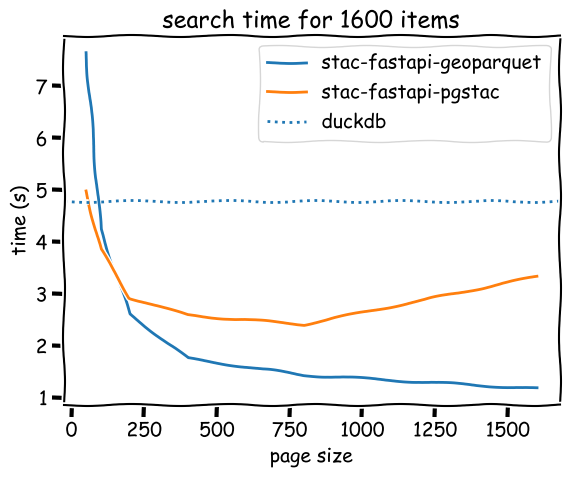

In [45]:
from matplotlib import pyplot

with pyplot.xkcd():
    pyplot.plot(PAGE_SIZES, geoparquet_results, label="stac-fastapi-geoparquet")
    pyplot.plot(PAGE_SIZES, pgstac_results, label="stac-fastapi-pgstac")
    pyplot.axhline(duckdb_result, label="duckdb", linestyle=":")
    pyplot.title("search time for 1600 items")
    pyplot.xlabel("page size")
    pyplot.ylabel("time (s)")
    pyplot.legend()
    pyplot.show()

In [46]:
NUMBER_OF_ITEMS = [50, 100, 200, 400, 800, 1600, 3200]

geoparquet_client = Client.open(STAC_FASTAPI_GEOPARQUET_URI)
pgstac_client = Client.open(STAC_FASTAPI_PGSTAC_URI)
duckdb_client = DuckdbClient()
duckdb_client.execute("CREATE SECRET (TYPE S3, PROVIDER CREDENTIAL_CHAIN)")

geoparquet_results = []
pgstac_results = []
duckdb_results = []

for max_items in NUMBER_OF_ITEMS:
    with Timer() as timer:
        items = list(
            geoparquet_client.search(
                collections=["naip"],
                limit=max_items,
                max_items=max_items,
            ).items_as_dicts()
        )
        geoparquet_results.append(timer.report(items))

    with Timer() as timer:
        items = list(
            pgstac_client.search(
                collections=["naip"], limit=max_items, max_items=max_items
            ).items_as_dicts()
        )
        pgstac_results.append(timer.report(items))

    with Timer() as timer:
        items = duckdb_client.search(
            NAIP_GEOPARQUET_URI, collections=["naip"], limit=max_items
        )
        duckdb_results.append(timer.report(items))

Retrieved 50 in 0.25s (201.75 items/s)
Retrieved 50 in 0.16s (315.43 items/s)
Retrieved 50 in 4.30s (11.62 items/s)
Retrieved 100 in 0.25s (403.69 items/s)
Retrieved 100 in 0.22s (451.18 items/s)
Retrieved 100 in 4.31s (23.18 items/s)
Retrieved 200 in 0.30s (663.66 items/s)
Retrieved 200 in 0.41s (493.37 items/s)
Retrieved 200 in 4.39s (45.57 items/s)
Retrieved 400 in 0.46s (876.41 items/s)
Retrieved 400 in 0.62s (646.62 items/s)
Retrieved 400 in 4.30s (93.02 items/s)
Retrieved 800 in 0.76s (1054.08 items/s)
Retrieved 800 in 1.23s (651.59 items/s)
Retrieved 800 in 4.44s (180.19 items/s)
Retrieved 1600 in 1.23s (1299.57 items/s)
Retrieved 1600 in 2.35s (681.32 items/s)
Retrieved 1600 in 4.29s (373.31 items/s)
Retrieved 3200 in 2.17s (1474.72 items/s)
Retrieved 3200 in 4.87s (657.21 items/s)
Retrieved 3200 in 4.45s (719.03 items/s)


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

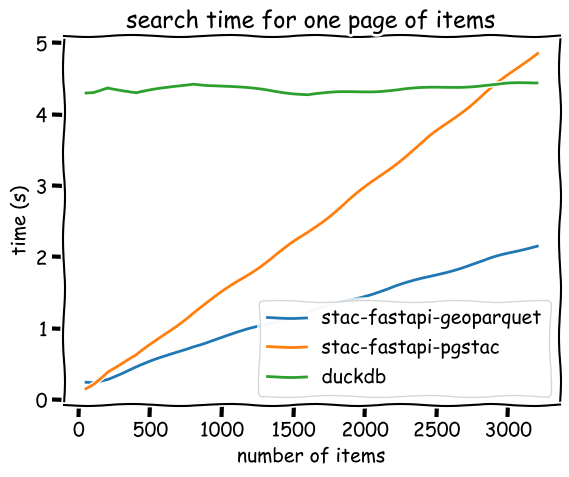

In [47]:
from matplotlib import pyplot

with pyplot.xkcd():
    pyplot.plot(NUMBER_OF_ITEMS, geoparquet_results, label="stac-fastapi-geoparquet")
    pyplot.plot(NUMBER_OF_ITEMS, pgstac_results, label="stac-fastapi-pgstac")
    pyplot.plot(NUMBER_OF_ITEMS, duckdb_results, label="duckdb")
    pyplot.title("search time for one page of items")
    pyplot.xlabel("number of items")
    pyplot.ylabel("time (s)")
    pyplot.legend()
    pyplot.show()